# Emulating the data for MassiveNus

## Import Packages

In [265]:
import os
import sys
import numpy as np
import pandas as pd
import time

In [266]:
from looti import dictlearn as dcl
from looti import datahandle as dhl
from looti import PlottingModule as pm

from looti import tools as too
from looti import PlottingModule as pm

In [267]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

The data is imported from pandas Dataframes which have been previously created using the `read_files` module.
The DataFrames contain the **k-grid** and the **power spectrum** at each redshift and each parameter variation, for the *extended model* and the *reference model*.

### Specify Paths

The DataFrames of the *extented model* and the *reference model* should be stored inside the same `data_folder`. The results of the experiments(plots, interpolation functions) are stored inside `the results_folder`

In [268]:
data_folder = '../../SimulationData/Massive_Nus/'
results_folder = './results/'

In [269]:
too.mkdirp(results_folder)    ## If directory does not exists, it is created here

### Load MassiveNus dataframes

The user has **two options** : provide the power **spectra** of the *extended* and *reference model* **OR** provide directly the **ratios** between these two models.

**Case 1** (spectra): user provides :
- datafile_ext : filename containing the power spectra of the extended model
- datafile_ref : filename containing the power spectra of the reference model (i.e. LCDM)

**Case 2** (ratios): user provides :
- datafile_ext : filename containing the ratios between the extended model and the reference model

In [270]:
###Name of the file for the external input data, without the extension
datafile_ext = 'Massive_Nus'
###Name of the file for the LCDM input data
datafile_ref = 'Massive_Nus_LCDM'

The following functions load the data into a object `emulation_data`. When the ratios are directly provide the user must indicate : `ratio_mode=True`

In [271]:
emulation_data = dhl.DataHandle( datafile_ext, data_folder, datafile_ref, num_parameters=3) 
emulation_data.read_csv_pandas() 

## Calculate power spectra ratios at all redshifts available

Available **redshifts** are stored in the attribute `z_vals`

In [272]:
# Available redshifts
emulation_data.z_vals

array([0.    , 0.2632, 0.5263, 0.7895, 1.0526, 1.3158, 1.5789, 1.8421,
       2.1053, 2.3684, 2.6316, 2.8947, 3.1579, 3.4211, 3.6842, 3.9474,
       4.2105, 4.4737, 4.7368, 5.    ])

The function `calculate_ratio_by_redshifts` computes the ratio between the *extended* and *reference* model at each **redshit** passed as argument.

The user can optionally decide to **normalize** the data by passing `normalize=False`. This option will force all the ratios to be equal to 1 at k = `pos_norm`

In [273]:
## Set normalize=False, since Fitting Formulae are already normalized
## First argument contains all the redshifts at which simulations are available
emulation_data.calculate_ratio_by_redshifts(emulation_data.z_vals,normalize=True)

# Define number of training and test

## Choose  the number of training vectors, test vectors and number of data splits

Available parameters are stored in the attribute `emulation_data.extparam_vals`

In [274]:
### Available parameters 
emulation_data.extparam_vals

array([0.06271, 0.06522, 0.06773, 0.07024, 0.07275, 0.07526, 0.07778,
       0.0803 , 0.08282, 0.08535, 0.08788, 0.09041, 0.09295, 0.0955 ,
       0.09805, 0.1    , 0.10061, 0.10318, 0.10575, 0.10833, 0.11092,
       0.11351, 0.11612, 0.11874, 0.12136, 0.124  , 0.12665, 0.12931,
       0.13198, 0.13467, 0.13737, 0.14008, 0.14281, 0.14556, 0.14832,
       0.1511 , 0.15389, 0.15671, 0.15954, 0.1624 , 0.16527, 0.16817,
       0.17109, 0.17404, 0.17701, 0.18001, 0.18303, 0.18409, 0.18608,
       0.18917, 0.19228, 0.19543, 0.19861, 0.20183, 0.20235, 0.20508,
       0.20837, 0.21171, 0.2118 , 0.21508, 0.21846, 0.21851, 0.22198,
       0.22371, 0.2255 , 0.22808, 0.22907, 0.23187, 0.2327 , 0.23522,
       0.23638, 0.23825, 0.24013, 0.24102, 0.24359, 0.24394, 0.24598,
       0.24782, 0.24823, 0.25036, 0.25177, 0.25238, 0.25432, 0.2558 ,
       0.25616, 0.25794, 0.25966, 0.25991, 0.26132, 0.26292, 0.26411,
       0.26449, 0.26601, 0.26749, 0.2684 , 0.26894, 0.27035, 0.27174,
       0.27278, 0.27

In [275]:
### Available parameters 
n_train = 102 # Number of training vectors without taking acount the extrema 
n_test = 1 # Number of test vectors without taking acount the extrema
n_splits = 1  # Number of splits
test_indices=[[1]]  ## List of list of indices, one list per split

The user can choose the number of **training and test vectors** used, the number of splits.

**Indices** of train and tets vectors can also be directly passed. These indices would correspond to the parameters listed above. If no indices are passed for the train vectors they would be randomly set.

In [276]:
emulation_data.calculate_data_split(n_train=n_train, ##number of training vectors/ redshift
                                    n_test=n_test, ##number of test vectors
                                    verbosity=0,
                                    manual_split=True,
                                    test_indices=test_indices,
                                    train_redshift_indices=[0],##Indices of the redshifts used for the train vect.
                                    test_redshift_indices=[0]) ##Indices of the redshifts used for the test vect.

#  PCA with GP interpolation

The following section performs a **reduction of dimensionality with PCA** and construct the **interpolation with a Gaussian Process**. Note that the level of noise for the GP's kernel should be chosen carefully.

In [277]:
npca = 80

In [373]:
Interpolation = Interpolating_function()

for i,redshift in enumerate(emulation_data.z_requested):

    ratios_predicted , emulation_data,interpolation_function = dcl.Predict_ratio(emulation_data,Operator = "PCA",
                                                          train_noise = 1e-3, ##noise for the GP's kernel
                                                          gp_n_rsts = 10,##times allowed to restart the optimiser
                                                          ncomp=npca , ##number of components
                                                          gp_const = 1, ##Constant for the RBF kernel
                                                          gp_length = 1 , ## Length for  GP 
                                                          interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                          n_splits = 1, ##number of splits
                                                          test_indices=test_indices,
                                                         train_redshift_indices = redshift_indice,
                                                         test_redshift_indices = redshift_indice,##indices of the test vectors
                                                         min_k =1e-2,max_k=10e1,return_interpolator=True)
    function = Interpolating_function_redshift (emulation_data,interpolation_function,redshift,normalize=True)
    Interpolation.redshift_available.append(redshift)
    Interpolation.list_interpolation_function.append(function)
    

('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)
('Shape of PCA matrix: (100, 80)',)
('Number of PCA components: 80',)


In [379]:
emulation_data.extparam_vals

array([0.06271, 0.06522, 0.06773, 0.07024, 0.07275, 0.07526, 0.07778,
       0.0803 , 0.08282, 0.08535, 0.08788, 0.09041, 0.09295, 0.0955 ,
       0.09805, 0.1    , 0.10061, 0.10318, 0.10575, 0.10833, 0.11092,
       0.11351, 0.11612, 0.11874, 0.12136, 0.124  , 0.12665, 0.12931,
       0.13198, 0.13467, 0.13737, 0.14008, 0.14281, 0.14556, 0.14832,
       0.1511 , 0.15389, 0.15671, 0.15954, 0.1624 , 0.16527, 0.16817,
       0.17109, 0.17404, 0.17701, 0.18001, 0.18303, 0.18409, 0.18608,
       0.18917, 0.19228, 0.19543, 0.19861, 0.20183, 0.20235, 0.20508,
       0.20837, 0.21171, 0.2118 , 0.21508, 0.21846, 0.21851, 0.22198,
       0.22371, 0.2255 , 0.22808, 0.22907, 0.23187, 0.2327 , 0.23522,
       0.23638, 0.23825, 0.24013, 0.24102, 0.24359, 0.24394, 0.24598,
       0.24782, 0.24823, 0.25036, 0.25177, 0.25238, 0.25432, 0.2558 ,
       0.25616, 0.25794, 0.25966, 0.25991, 0.26132, 0.26292, 0.26411,
       0.26449, 0.26601, 0.26749, 0.2684 , 0.26894, 0.27035, 0.27174,
       0.27278, 0.27

In [374]:
import pickle
with open('interpolating_function_Massive_Nus', 'wb') as f:
    pickle.dump(Interpolation, f)

with open('interpolating_function_Massive_Nus', 'rb') as f:
    Interpolation_loaded = pickle.load(f)


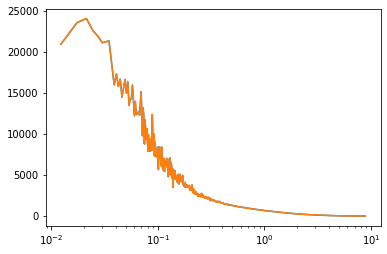

In [378]:
plt.semilogx(np.power(10,emulation_data.masked_k_grid),[Interpolation_loaded.predict(0.0,k,[0.06271,0.38154,2.2004]) for k in np.power(10,emulation_data.masked_k_grid) ])

plt.semilogx(np.power(10,emulation_data.masked_k_grid),emulation_data.df_ext.loc["theo",0.0,"mnv",0.06271,"om",0.38154,"As",2.2004].values)

In [368]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 18 16:47:54 2020

@author: raphaelbaena
"""

class Interpolating_function :
    def __init__(self):
        self.redshift_available = []
        self.list_interpolation_function = []
        
    def predict(self,z,k,parameters):
        
        parameters = [z] + parameters
        parameters = np.atleast_2d(parameters)
        ind_z_min,ind_z_max= self.extrema(z)
        z_min, z_max = self.redshift_available[ind_z_min],self.redshift_available[ind_z_max]
        
        f_min = self.list_interpolation_function[ind_z_min].predict(k,parameters)
        f_max = self.list_interpolation_function[ind_z_max].predict(k,parameters)
        
        interpolation_function_at_z = interpolate.interp1d([z_min, z_max ],[f_min,f_max])
        return float(interpolation_function_at_z (z))
    
    def extrema(self,z):
        ind_argmin = np.abs(np.array(self.redshift_available) - z).argmin()
        if self.redshift_available[ind_argmin]>z:
            return ind_argmin-1,ind_argmin
        else : 
            return ind_argmin,ind_argmin+1
        
from scipy import interpolate

class Interpolating_function_redshift :
    def __init__(self,emulation_data,interpolation_function,redshift,normalize = False):
        self.k_grid = np.power(10,emulation_data.masked_k_grid)
        self.redshift =  redshift
        self.spectra_ref = emulation_data.df_ref.loc[emulation_data.level_of_noise,
                                                     self.redshift].values.flatten()[emulation_data.mask_true]
        self.interpolation_function_factor = dcl.Interpolate_over_factor(emulation_data, pos_norm = emulation_data.pos_norm)
        self.interpolation_function = interpolation_function
        self.normalize = normalize 
        self.parameters_predicted=[] ##talk with Santiago about it !
        self.saved_interpolation ={}
    def predict_each_k(self,parameters):
        ratio = np.array(list(self.interpolation_function.predict(parameters).values())).flatten() 
        spectra = ratio * self.spectra_ref
        if self.normalize == True :
            F_norm = self.interpolation_function_factor.predict(parameters)
        else:
            F_norm = 1
            print("f",F_norm)
        spectra_normalised = spectra* F_norm
       
        return spectra_normalised 
    def predict(self,k,parameters,linear_grid=False):
        parameters = np.atleast_2d(parameters)
        tupled_param = tuple(parameters.flatten())
        
        if tupled_param  not in self.parameters_predicted:
            self.interpolation_function_each_k = interpolate.interp1d(self.k_grid,self.predict_each_k(parameters))
            self.parameters_predicted.append(tupled_param)
            
            self.saved_interpolation[tupled_param ]=self.interpolation_function_each_k
        return float(self.saved_interpolation[tupled_param ](k))
        




In [241]:
redshifts = np.linspace(0,0.5,10)

In [242]:
[redshifts[0],redshifts[1]]

[0.0, 0.05555555555555555]

In [208]:
def extrema(z =0.4):
    ind_argmin = np.abs(redshifts - z).argmin()
    if redshifts[ind_argmin]>z:
        return redshifts[ind_argmin-1],redshifts[ind_argmin]
    else : 
        return redshifts[ind_argmin],redshifts[ind_argmin+1]
    
    

In [209]:
ex

NameError: name 'ex' is not defined

In [210]:
extrema()

(0.38888888888888884, 0.4444444444444444)

In [189]:
function.parameters_predicted

[]

In [229]:
function = Interpolating_function_redshift (emulation_data,interpolation_function,0,normalize=True)

In [196]:
emulation_data.train_samples

array([[0.     , 0.06271, 0.38154, 2.2004 ],
       [0.     , 0.06773, 0.41591, 1.6231 ],
       [0.     , 0.07024, 0.20235, 2.3075 ],
       [0.     , 0.07275, 0.32826, 2.2883 ],
       [0.     , 0.07526, 0.33551, 1.5659 ],
       [0.     , 0.07778, 0.25966, 2.4333 ],
       [0.     , 0.0803 , 0.27832, 2.3824 ],
       [0.     , 0.08282, 0.27575, 1.8292 ],
       [0.     , 0.08535, 0.31316, 1.9913 ],
       [0.     , 0.08788, 0.29264, 1.7376 ],
       [0.     , 0.09041, 0.28447, 2.1757 ],
       [0.     , 0.09295, 0.31553, 2.4949 ],
       [0.     , 0.0955 , 0.35898, 2.4624 ],
       [0.     , 0.09805, 0.30056, 1.9744 ],
       [0.     , 0.1    , 0.3    , 2.1    ],
       [0.     , 0.10061, 0.27958, 2.0161 ],
       [0.     , 0.10318, 0.39765, 2.2607 ],
       [0.     , 0.10575, 0.30509, 1.9117 ],
       [0.     , 0.10833, 0.28327, 2.3595 ],
       [0.     , 0.11092, 0.37629, 2.0404 ],
       [0.     , 0.11351, 0.18409, 1.7932 ],
       [0.     , 0.11612, 0.30851, 1.8056 ],
       [0.

In [230]:
grid= np.linspace(0.04,6,100)
pred_1 = [ function.predict(k,[0,0.07,0.9,2]) for k in grid]
pred_2 = [ function.predict(k,[0,0.1,0.3,2]) for k in grid]


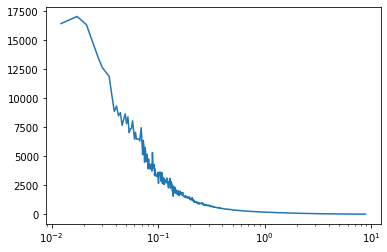

In [136]:
import matplotlib.pyplot as plt


ratio = np.array(list(interpolation_function.predict(emulation_data.test_samples).values())).flatten() 
spectra =ratio * LCDM_ref
F_norm = Interpolation_function_factor.predict (emulation_data.test_samples)
spectra_normalised = spectra*F_norm
plt.semilogx(np.power(10,K_grid),spectra_normalised)

The user can access to the train and test samples :

In [18]:
### Test Samples
emulation_data.test_samples

array([[0.     , 0.06522, 0.28205, 1.8826 ]])

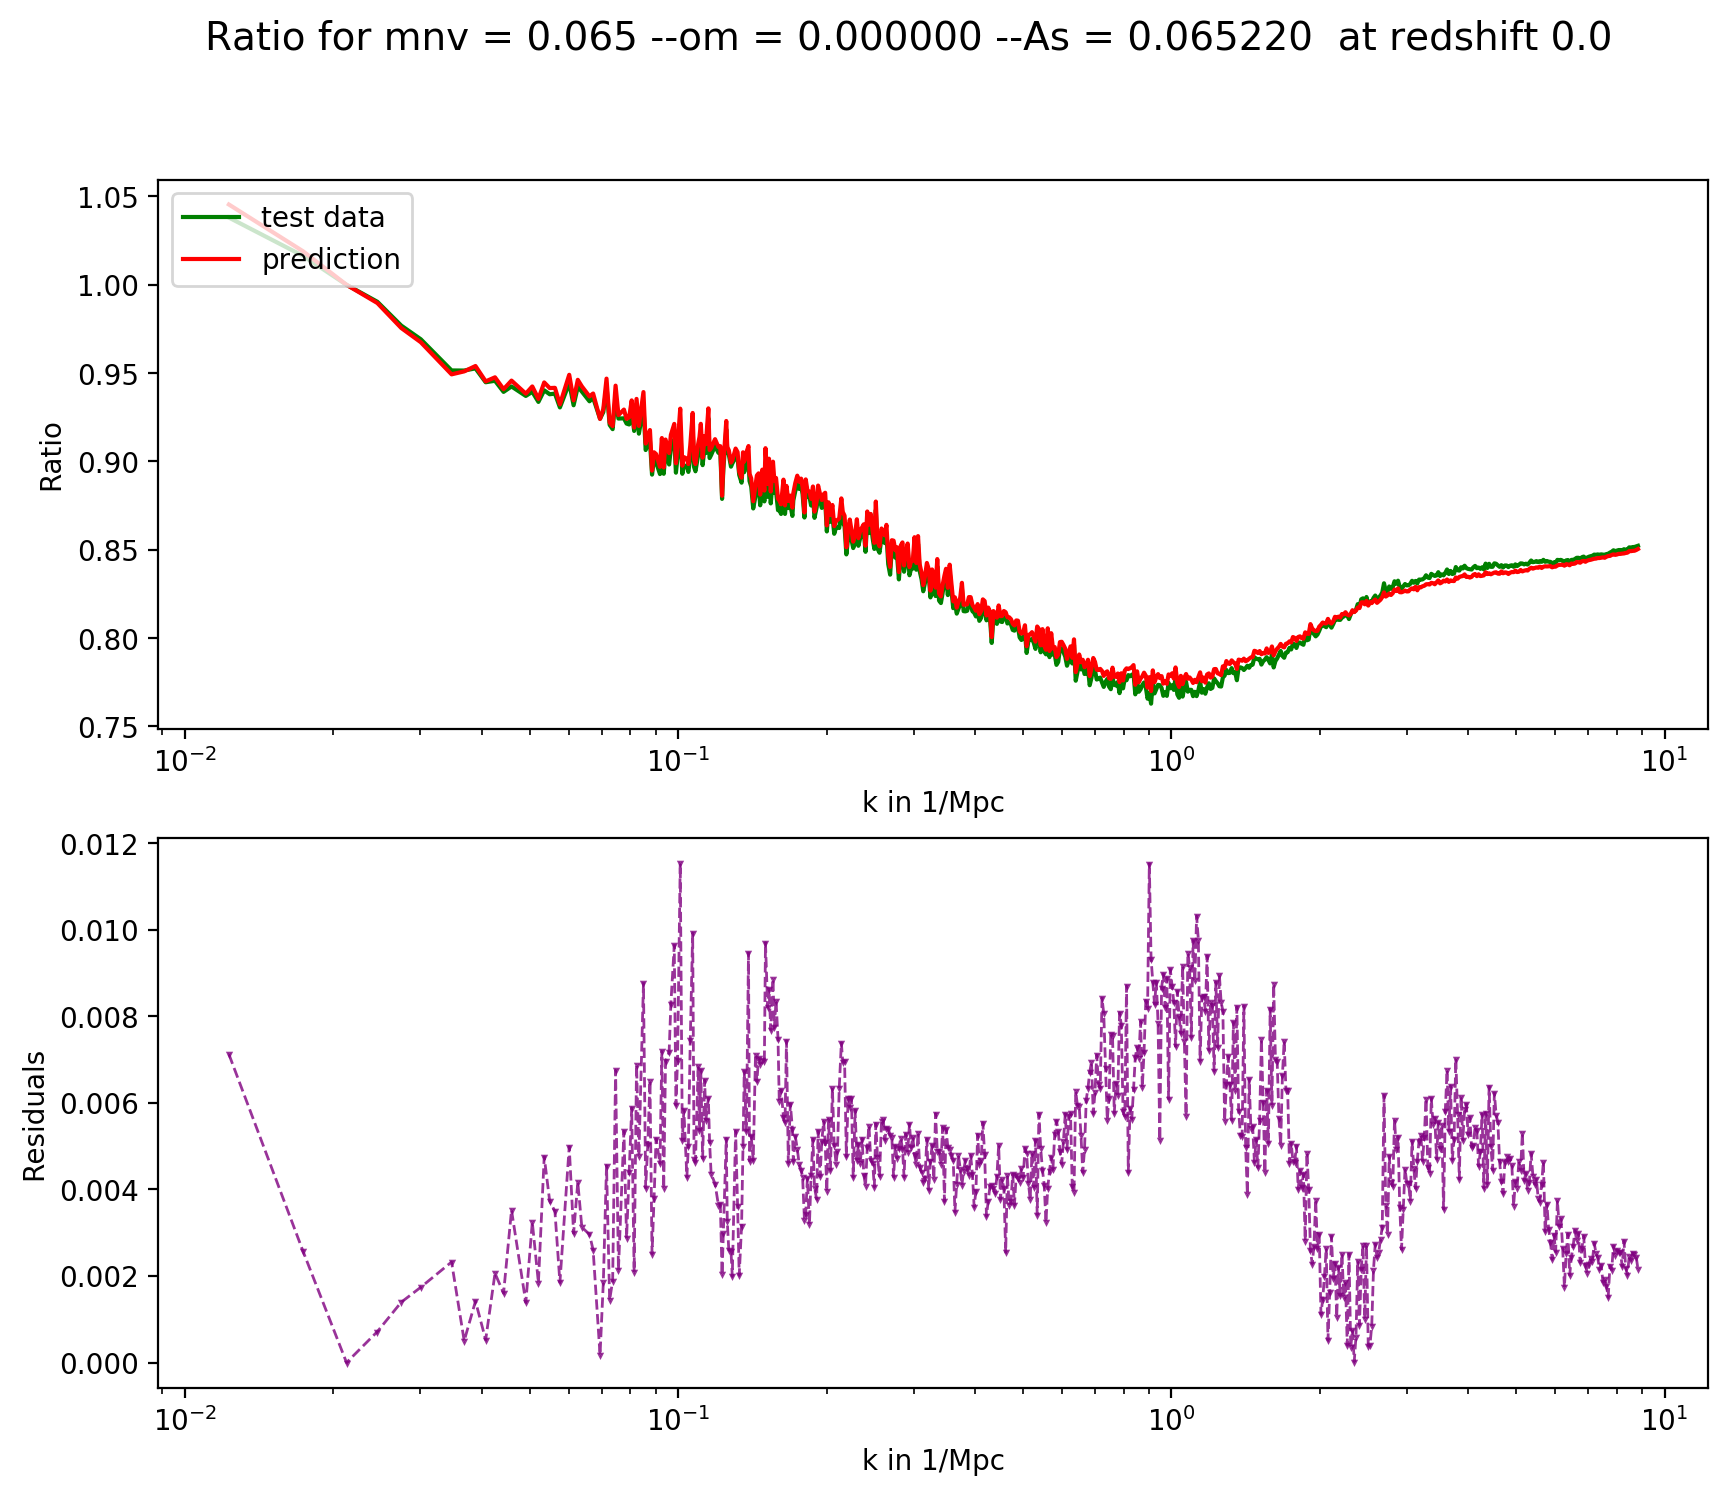

In [19]:
pm.Plot_prediction_One_parameter(emulation_data, 0.092 , ratios_predicted)

RMSE of normalisation factor 0.29760240418205264


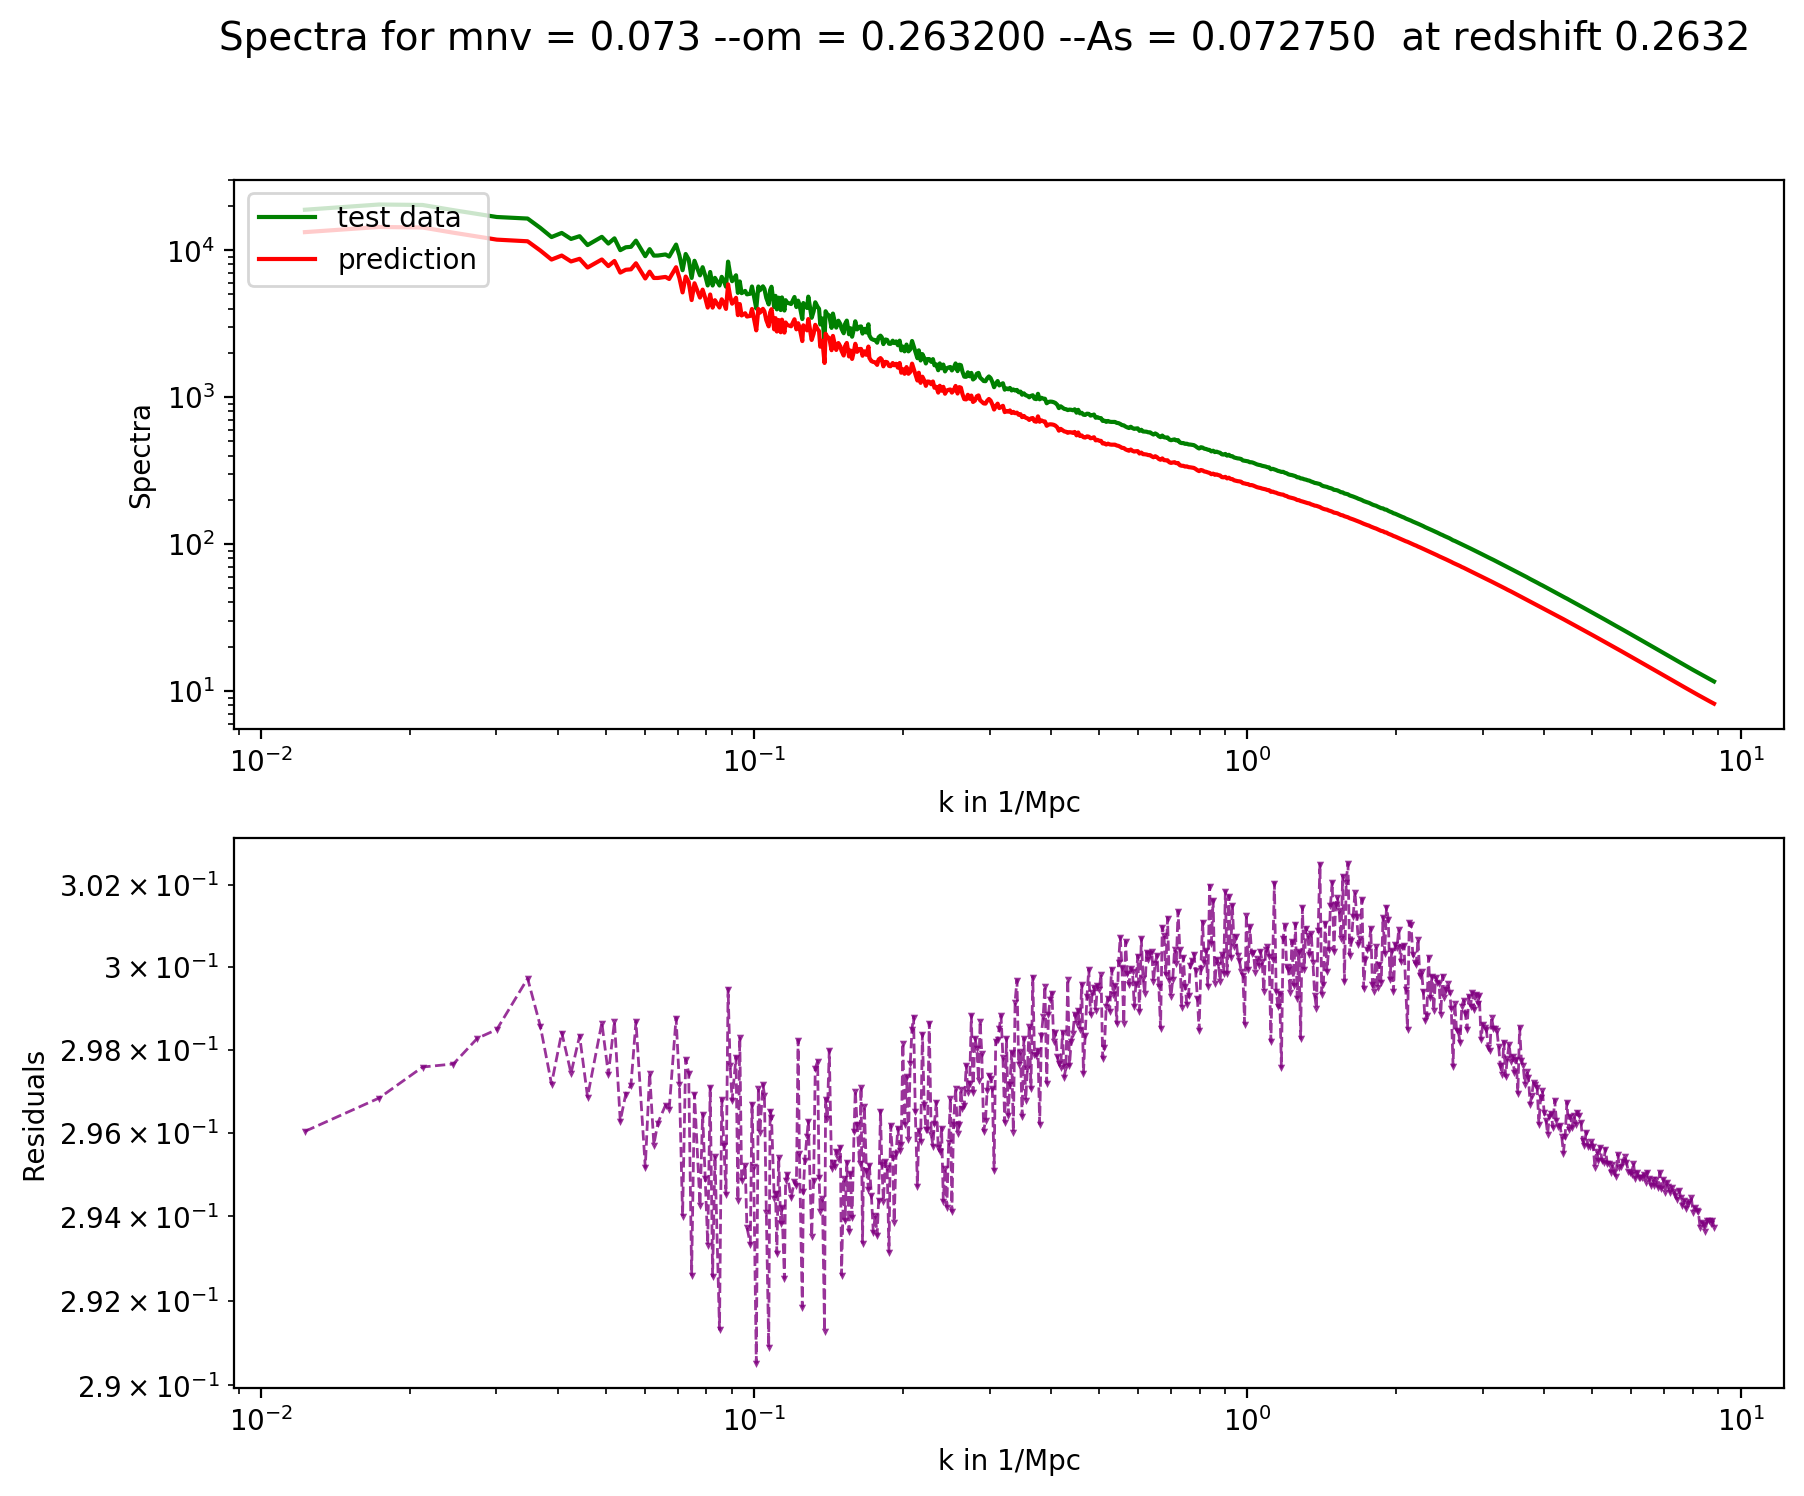

In [98]:
reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data,normalization=True)
pm.Plot_prediction_One_parameter(emulation_data, 0.098 , reconstructed_spectra,ratio_mode=False,y_scale_log=True)

# GP Example

The following section performs construct the **interpolation with a Gaussian Process**. Note that the level of noise for the GP's kernel should be chosen carefully.

In [90]:
ratios_predicted , emulation_data = dcl.Predict_ratio(emulation_data,Operator = "GP",
                                                      train_noise = 1e-7, ##noise for the GP's kernel
                                                      gp_n_rsts = 10,##times allowed to restart the optimiser
                                                      ncomp=npca , ##number of components
                                                      gp_const = 1, ##Constant for the RBF kernel
                                                      gp_length = 1 , ## Length for  GP 
                                                      interp_type='GP', ##kind of interpolator,e.g int1d or GP 
                                                      n_splits = n_splits, ##number of splits
                                                      test_indices=test_indices, ##indices of the test vectors/redshift 
                                                      train_redshift_indices= [1], ##indices of the reshift used for train 
                                                      test_redshift_indices= [1] )##indices of the reshift used for test 

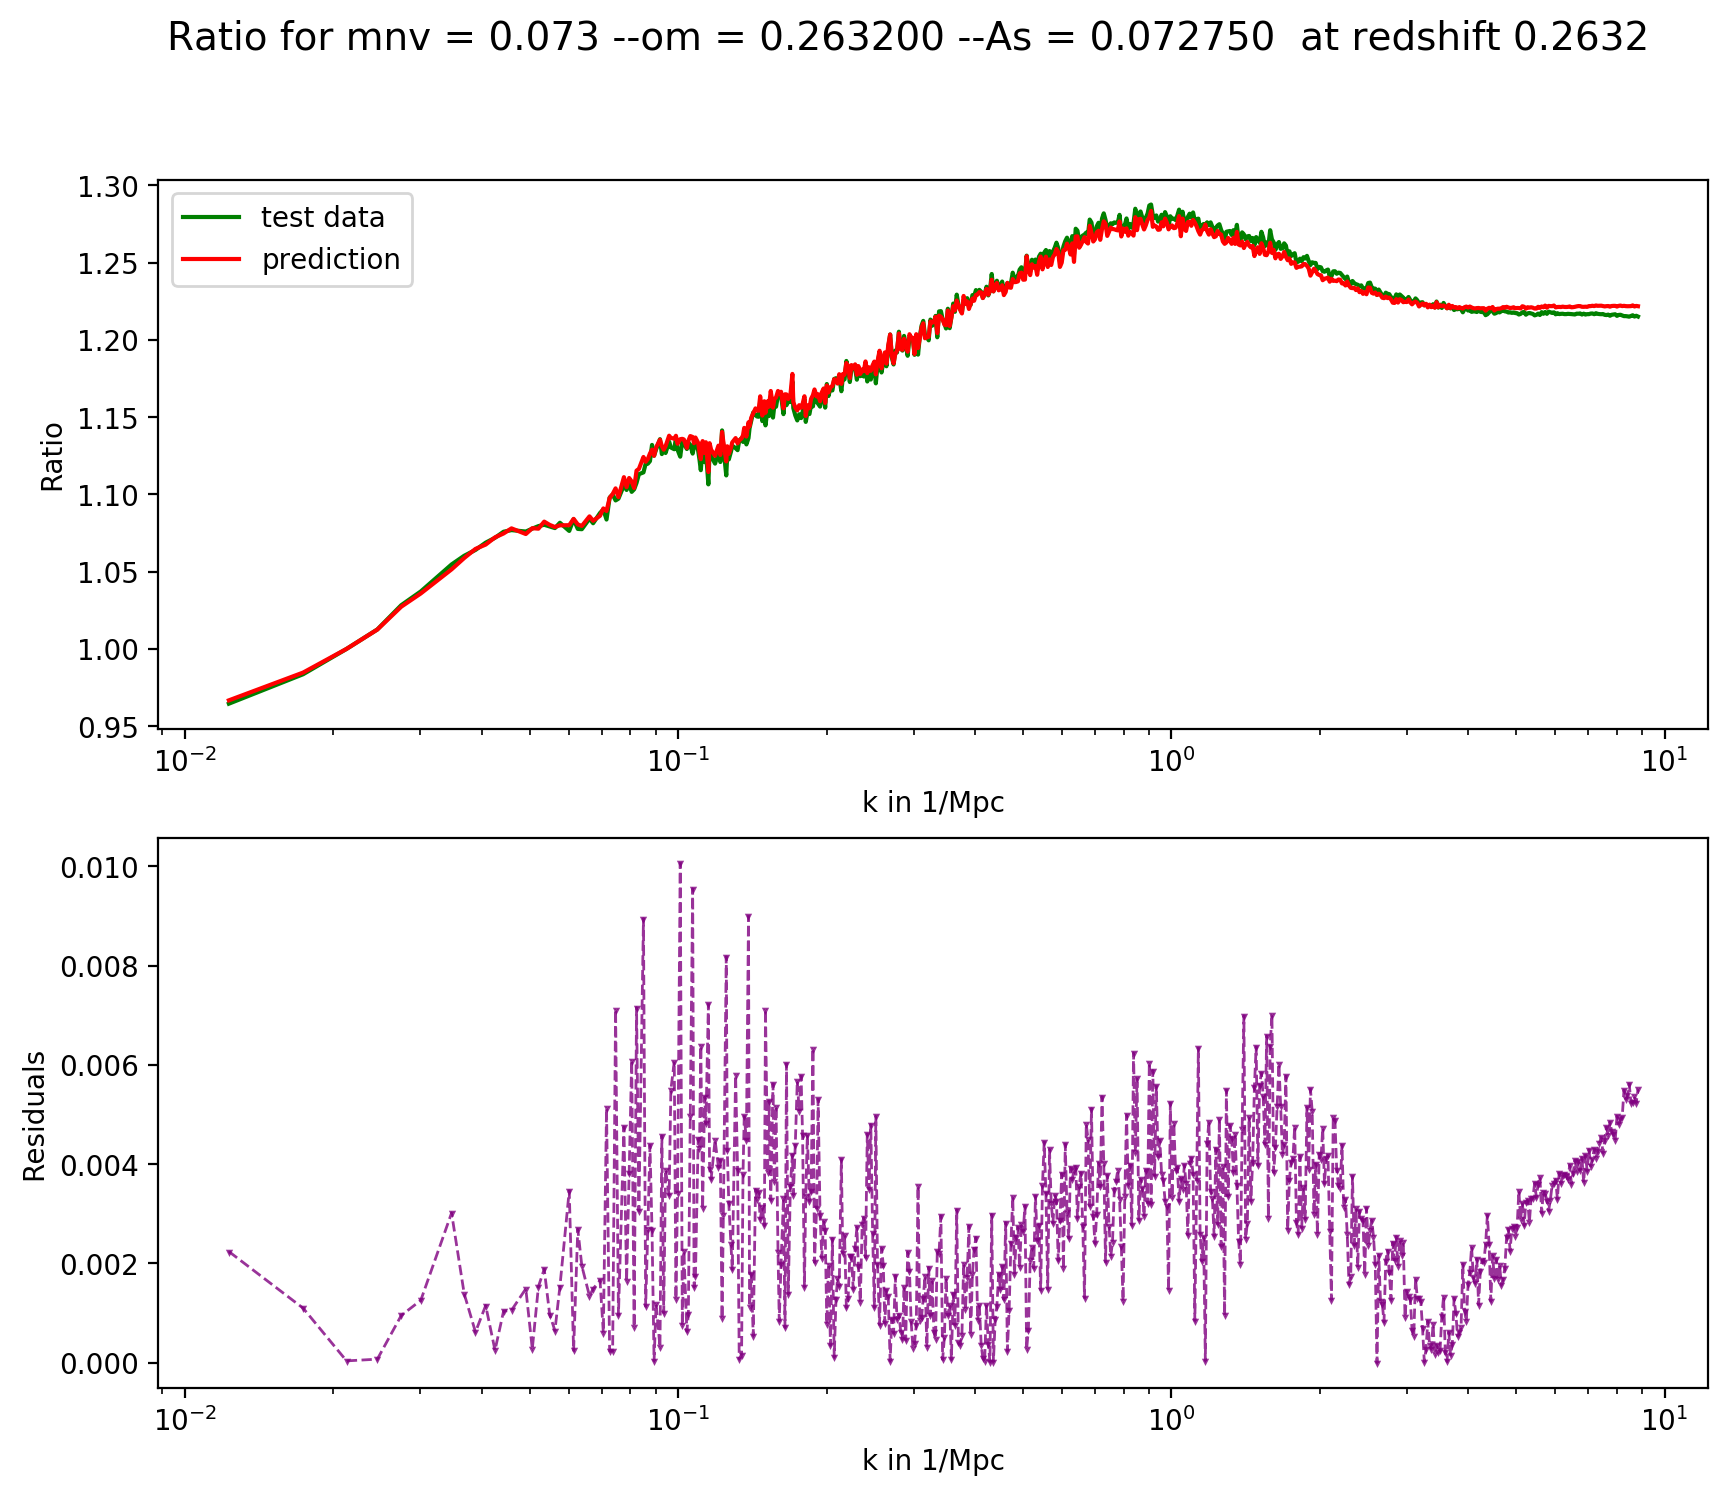

In [96]:
pm.Plot_prediction_One_parameter(emulation_data, 0.098,ratios_predicted)

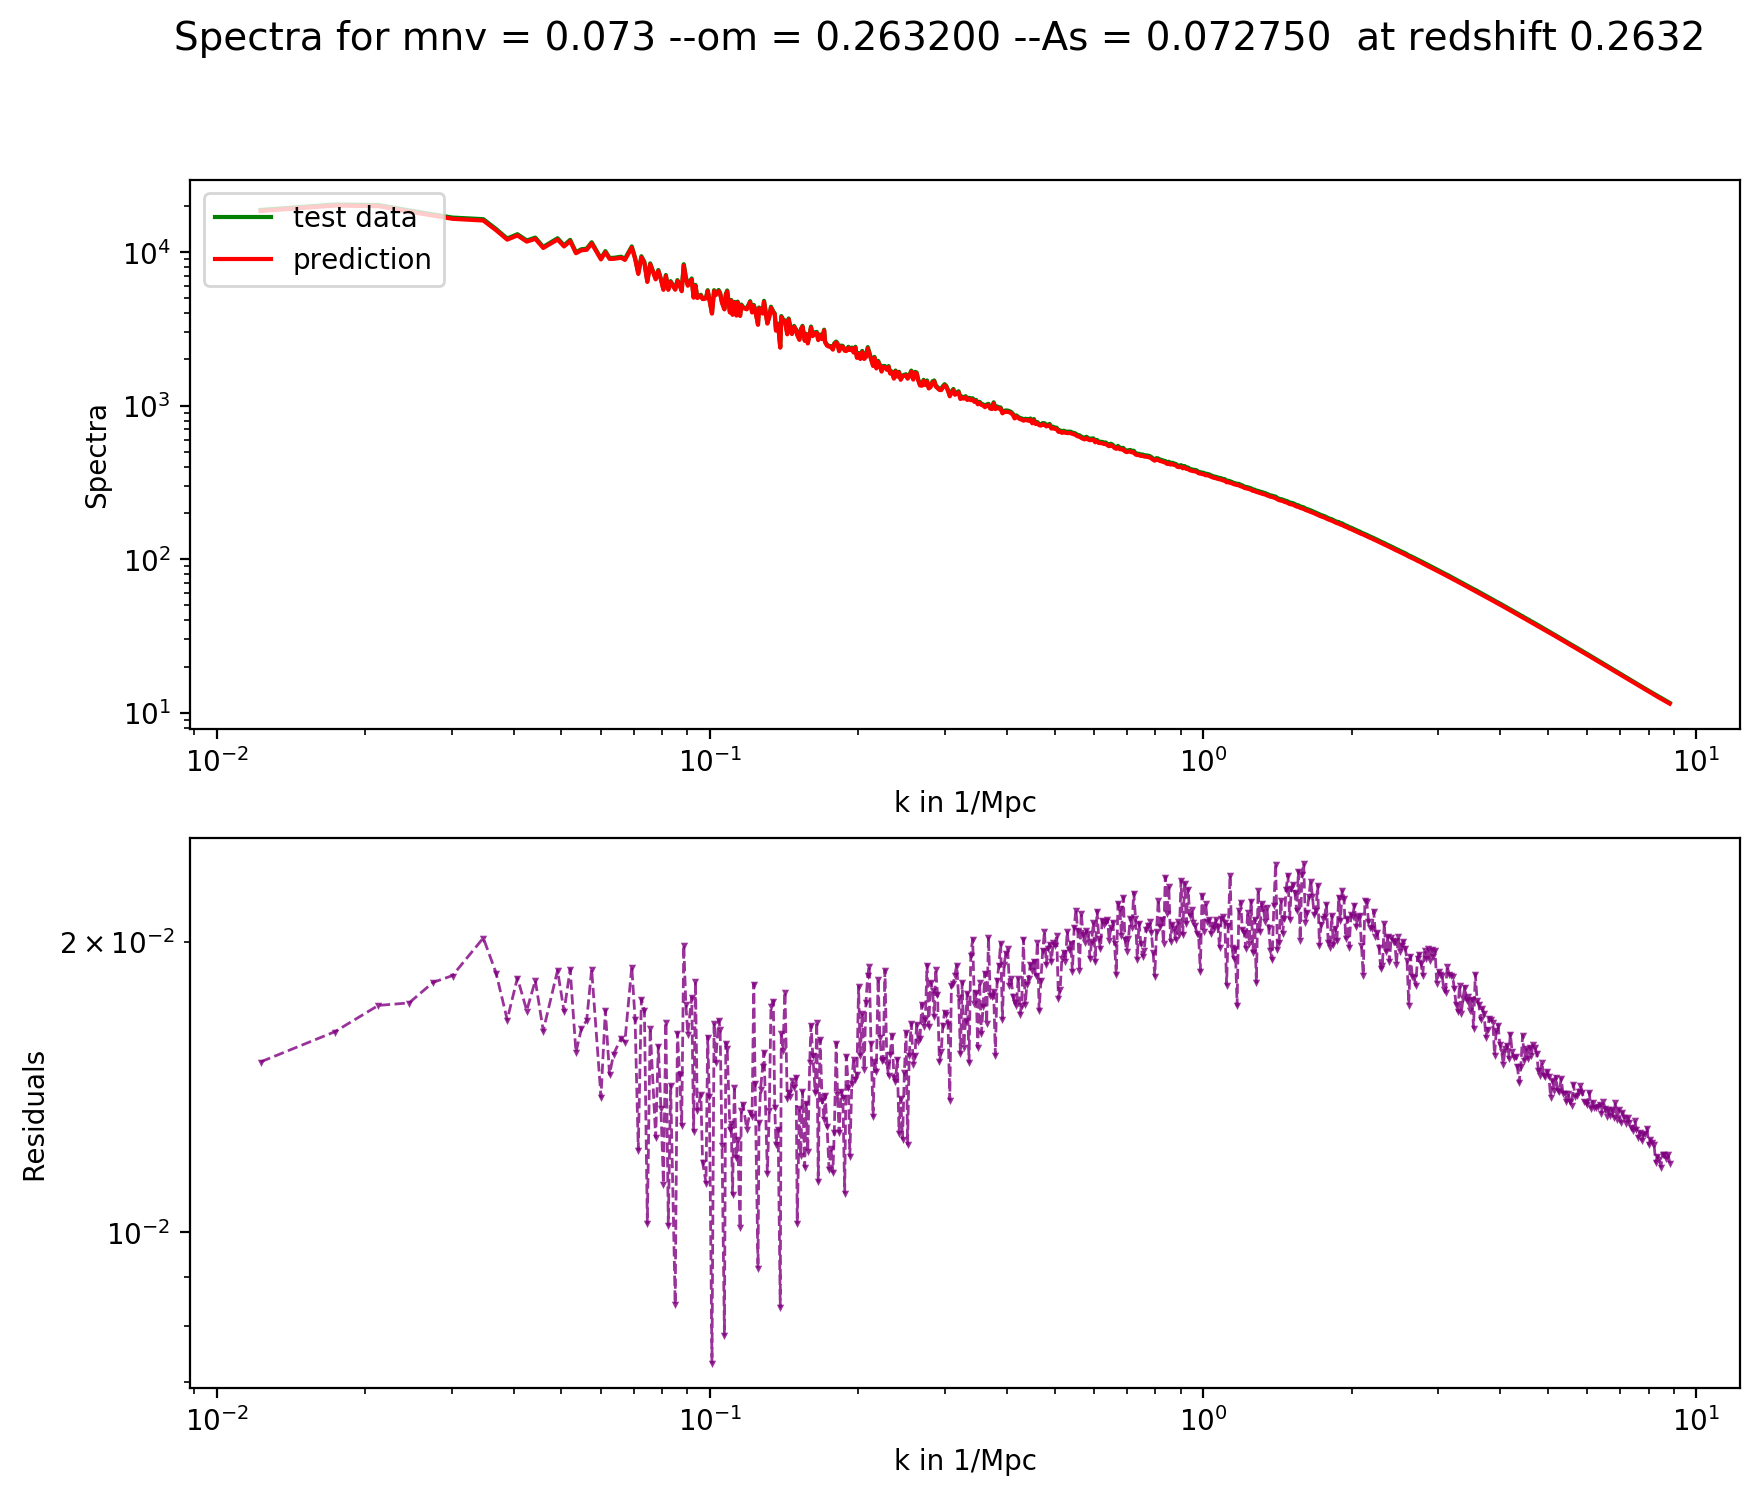

In [97]:
reconstructed_spectra = dcl.reconstruct_spectra(ratios_predicted,emulation_data = emulation_data,normalization=False)
pm.Plot_prediction_One_parameter(emulation_data, 0.098 , reconstructed_spectra,ratio_mode=False,y_scale_log=True)